In [273]:
import torch
import torch.nn as nn
import torch.optim as optimim
import torch.nn.functional as Func
import sys, os, numpy as np
import importlib
import matplotlib.pyplot as plt

In [274]:
# 1. 정확한 경로 입력
top_py_path = "/workspace/__MAPS__/200x200/top.py"  # ← 여기를 네 환경에 맞게 확인!

# 2. importlib을 통해 top.py 모듈 로딩
spec = importlib.util.spec_from_file_location("top", top_py_path)
top = importlib.util.module_from_spec(spec)
spec.loader.exec_module(top)

# 3. top.py 안에 MAP이 정의되어 있는지 확인
print("top.py loaded, keys:", dir(top))  # 이걸로 확인해보자!

# 4. MAP 가져오기
MAP = np.array(top.MAP)
print("MAP loaded successfully, shape:", MAP.shape)

top.py loaded, keys: ['MAP', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__']
MAP loaded successfully, shape: (40, 40)


In [275]:
class Reinforcement:
    def __init__(self, map_tensor, coverage_size=45):
        if isinstance(map_tensor, np.ndarray):
            map_tensor = torch.tensor(map_tensor).float()  # ✅ numpy → torch 변환

        self.map_tensor = map_tensor.clone()
        self.coverage_size = coverage_size

        # 👇 센서 커버를 표현할 맵 (0으로 초기화)
        self.covered_map = torch.zeros_like(self.map_tensor)

    def apply_coverage(self, x, y, radius=None):
        if radius is None:
            radius = self.coverage_size

        half_size = radius // 2
        H, W = self.covered_map.shape
        xmin = max(0, x - half_size)
        xmax = min(H, x + half_size + 1)
        ymin = max(0, y - half_size)
        ymax = min(W, y + half_size + 1)

        # 📡 커버된 영역 값을 증가시킴
        self.covered_map[xmin:xmax, ymin:ymax] += 1

    def get_numeric_state(self):
        return self.covered_map


    
    def show_map_image(self):
        """📊 현재 커버된 맵 상태를 시각화해보장~!"""
        plt.figure(figsize=(10, 10))
        plt.imshow(self.covered_map.numpy(), cmap='viridis')
        plt.title("🛰️ Sensor Coverage Map")
        plt.colorbar(label="Coverage Level")
        plt.tight_layout()
        plt.show()

In [276]:
reinforce = Reinforcement(MAP, 45)
reinforce.apply_coverage(10, 10, radius=5)
reinforce.apply_coverage(15, 15, radius=5)

state_tensor = reinforce.get_numeric_state()
print(state_tensor.shape)  # torch.Size([H, W])
print(state_tensor)


torch.Size([40, 40])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


/tmp/ipykernel_189150/172336004.py:37: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from current font.
  plt.tight_layout()


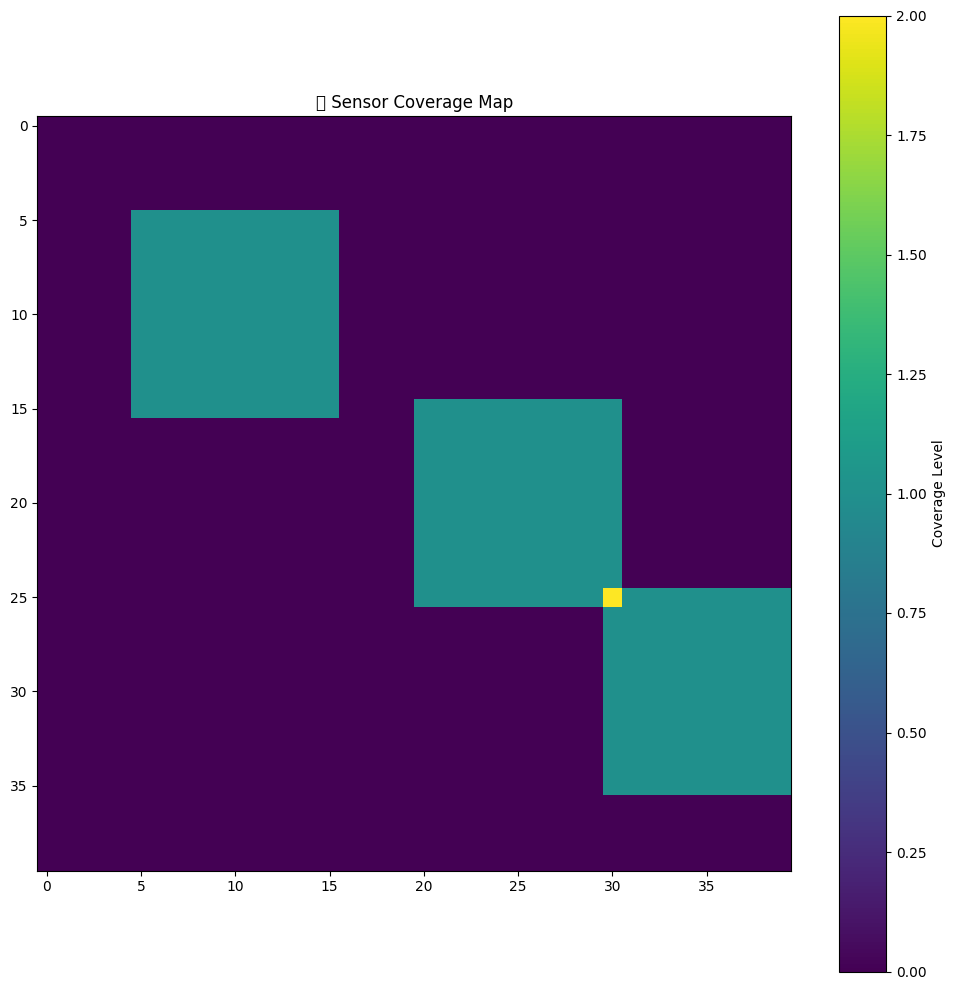

In [277]:
# Reinforcement 객체 생성
reinforce = Reinforcement(MAP, 45)

# 센서 배치
reinforce.apply_coverage(10, 10, radius=10)
reinforce.apply_coverage(20, 25, radius=10)
reinforce.apply_coverage(30, 35, radius=10)

# 시각화 (matplotlib)
reinforce.show_map_image()


In [278]:
import torch.nn as nn
import torch.nn.functional as F

class PlacementHeatmapUNet(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()

        # --- Encoder ---
        self.enc1 = self.block(input_channels, 16)
        self.enc2 = self.block(16, 32)
        self.enc3 = self.block(32, 64)

        # --- Bottleneck ---
        self.bottleneck = self.block(64, 128)

        # --- Decoder ---
        self.up3 = self.upblock(128, 64)
        self.up2 = self.upblock(64 + 64, 32)
        self.up1 = self.upblock(32 + 32, 16)

        # --- Output ---
        self.out_conv = nn.Conv2d(16 + 16, 1, kernel_size=1)  # output: (B, 1, H, W)

    def block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
        )

    def upblock(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2),
            nn.ReLU()
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)               # -> [B, 16, H, W]
        e2 = self.enc2(F.max_pool2d(e1, 2))  # -> [B, 32, H/2, W/2]
        e3 = self.enc3(F.max_pool2d(e2, 2))  # -> [B, 64, H/4, W/4]

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e3, 2))  # -> [B, 128, H/8, W/8]

        # Decoder
        d3 = self.up3(b)              # -> [B, 64, H/4, W/4]
        d3 = torch.cat([d3, e3], dim=1)

        d2 = self.up2(d3)             # -> [B, 32, H/2, W/2]
        d2 = torch.cat([d2, e2], dim=1)

        d1 = self.up1(d2)             # -> [B, 16, H, W]
        d1 = torch.cat([d1, e1], dim=1)

        out = self.out_conv(d1)       # -> [B, 1, H, W]
        return out.squeeze(1)         # -> [B, H, W]


In [279]:
def preprocess_map_tensor(map_tensor):
    processed = torch.zeros_like(map_tensor)

    processed[map_tensor == 1] = 20.0       # 설치 필요 → 강하게!
    processed[map_tensor == 10] = 1.0       # 커버만 됨 → 약하게
    processed[map_tensor == 11] = 0.0       # 센서 설치 → 무시
    processed[map_tensor >= 21] = -5.0      # 과잉 커버 → 억제
    processed[map_tensor == 0] = -10.0      # 지형 → 강한 음수

    return processed.unsqueeze(0)  # (1, 1, H, W)



In [280]:
model = PlacementHeatmapUNet()
input_tensor = preprocess_map_tensor(reinforce.MAP).unsqueeze(0)  # (1, 1, H, W)

with torch.no_grad():
    heatmap = model(input_tensor)  # (1, H, W)
    heatmap = heatmap.squeeze(0)

plt.figure(figsize=(10, 10))
plt.imshow(heatmap.numpy(), cmap='hot', vmin=0, vmax=20)
plt.title("🔥 Sensor Evaluation Heatmap (U-Net)")
plt.colorbar(label="Urgency Score")
plt.tight_layout()
plt.show()


AttributeError: 'Reinforcement' object has no attribute 'MAP'

In [ ]:
def make_gt_tensor(map_tensor):
    gt = torch.zeros_like(map_tensor)
    gt[map_tensor == 1] = 1.0
    return gt.unsqueeze(0)  # (1, H, W)

In [ ]:
import torch.optim as optim

model = PlacementHeatmapUNet()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()  # 로그 안 거친 출력값에 적합

In [ ]:
def make_gt_tensor_real(map_tensor):
    gt = torch.zeros_like(map_tensor)

    # 설치 필요 → 양의 강한 값
    gt[map_tensor == 1] = 10.0

    # 과잉 커버 → 음의 값
    gt[map_tensor >= 21] = -5.0

    # 이미 설치된 곳 → 0으로 유도
    gt[map_tensor == 11] = 0.0

    # 지형 → 약한 음수
    gt[map_tensor == 0] = -2.0

    return gt.unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)


In [ ]:
def custom_loss(output, target, map_tensor):
    """
    output: (1, 1, H, W)
    target: (1, 1, H, W)
    map_tensor: (H, W)
    """
    # (1, 1, H, W)로 reshape
    map_tensor = map_tensor.unsqueeze(0).unsqueeze(0)

    weights = torch.ones_like(target)

    weights[map_tensor == 1] = 5.0      # 설치 필요 영역
    weights[map_tensor == 11] = 0.2     # 이미 설치된 영역
    weights[map_tensor >= 21] = 2.0     # 과잉 커버
    weights[map_tensor == 0] = 3.0      # 장애물

    loss = F.binary_cross_entropy_with_logits(output, target, weight=weights)
    return loss


In [ ]:
def custom_loss_real(output, target):
    """
    output: (1, 1, H, W)
    target: (1, 1, H, W)
    """
    return F.smooth_l1_loss(output, target)


In [ ]:
gt_tensor = make_gt_tensor_real(reinforce.MAP)  # 실수 기반
input_tensor = preprocess_map_tensor(reinforce.MAP).unsqueeze(0)

model.train()
for epoch in range(500):
    optimizer.zero_grad()

    output = model(input_tensor).unsqueeze(1)
    loss = custom_loss_real(output, gt_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"[Epoch {epoch+1}] Real-Valued Loss: {loss.item():.4f}")


[Epoch 50] Real-Valued Loss: 0.7650
[Epoch 100] Real-Valued Loss: 0.1561
[Epoch 150] Real-Valued Loss: 0.0201
[Epoch 200] Real-Valued Loss: 0.0018
[Epoch 250] Real-Valued Loss: 0.0005
[Epoch 300] Real-Valued Loss: 0.0002
[Epoch 350] Real-Valued Loss: 0.0006
[Epoch 400] Real-Valued Loss: 0.0001
[Epoch 450] Real-Valued Loss: 0.0009
[Epoch 500] Real-Valued Loss: 0.0001


/tmp/ipykernel_189150/2633866654.py:8: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  plt.tight_layout()


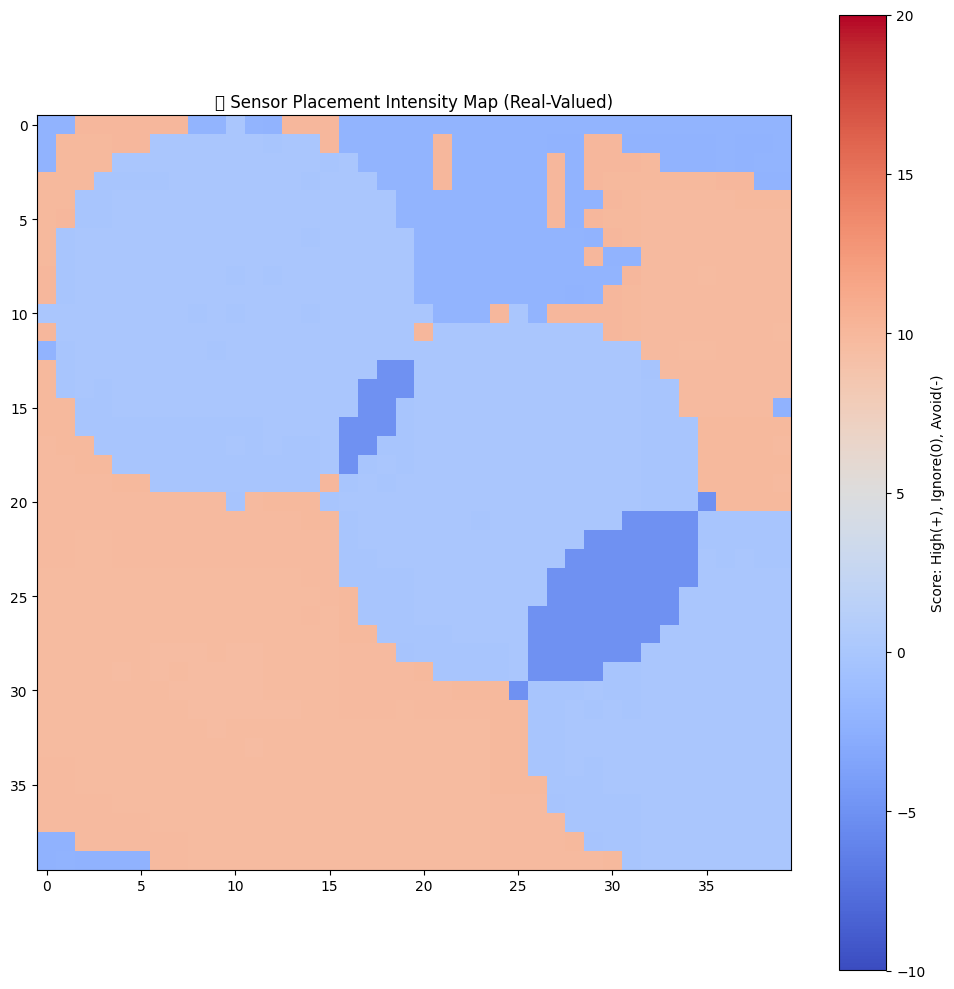

In [ ]:
model.eval()
with torch.no_grad():
    pred = model(input_tensor).squeeze(0)
    plt.figure(figsize=(10, 10))
    plt.imshow(pred.numpy(), cmap='coolwarm', vmin=-10, vmax=20)
    plt.title("🚨 Sensor Placement Intensity Map (Real-Valued)")
    plt.colorbar(label="Score: High(+), Ignore(0), Avoid(-)")
    plt.tight_layout()
    plt.show()


In [ ]:
import gymnasium as gym
from gymnasium import spaces

In [ ]:
class SensorPlacementEnv(gym.Env):
    def __init__(self, map_tensor, max_sensors=10):
        super().__init__()
        self.map_tensor = map_tensor.clone()
        self.map = map_tensor.clone()
        self.max_sensors = max_sensors
        self.current_step = 0
        self.reinforce = Reinforcement(map_tensor, 45)  # ✅ map_tensor로 고침
        self.height, self.width = self.map.shape
        self.H, self.W = self.map_tensor.shape

        self.action_space = spaces.Discrete(self.height * self.width)
        self.observation_space = spaces.Box(low=0, high=255,
                                            shape=(self.height * self.width,),
                                            dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.reinforce.covered_map.zero_()  # ✅ 커버 맵 초기화
        return self._get_observation(), {}

    def step(self, action):
        x = action // self.W
        y = action % self.W

        self.current_step += 1

        if self.map_tensor[x, y] >= 11:
            reward = -2.0  # ❗ 중복 설치 → 강한 패널티
        else:
            reward = self._compute_reward(x, y)
            self.map_tensor[x, y] += 10  # 센서 설치

        obs = self._get_observation()
        done = self.current_step >= self.max_sensors
        return obs, reward, done, False, {}



    def _get_observation(self):
        return self.reinforce.covered_map.flatten().numpy()  # ✅ 커버맵 기준 관측값

    def _compute_reward(self, x, y):
        if self.map_tensor[x, y] == 1:
            return 1.0
        elif self.map_tensor[x, y] >= 21:
            return -1.0  # 과잉 커버
        elif self.map_tensor[x, y] == 11:
            return -0.5  # 중복
        else:
            return -1.0


    def index_to_xy(self, index):
        x = index // self.width
        y = index % self.width
        return int(x), int(y)


In [ ]:
class PlacementHeatmapEvaluator(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x.squeeze(1)  # (B, H, W)


In [ ]:
class Reinforcement:
    def __init__(self, map_tensor, coverage_size=45):
        self.map_tensor = map_tensor.clone()
        self.coverage_size = coverage_size

        # 👇 센서 커버를 표현할 맵 (0으로 초기화)
        self.covered_map = torch.zeros_like(self.map_tensor)

    def apply_coverage(self, x, y):
        # 예시: 특정 범위 커버
        half_size = self.coverage_size // 2
        H, W = self.covered_map.shape
        xmin = max(0, x - half_size)
        xmax = min(H, x + half_size + 1)
        ymin = max(0, y - half_size)
        ymax = min(W, y + half_size + 1)

        # 📡 커버된 영역 값을 증가시킴
        self.covered_map[xmin:xmax, ymin:ymax] += 1

    def get_numeric_state(self):
        return self.covered_map


In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

env = SensorPlacementEnv(reinforce.MAP, max_sensors=100)
check_env(env, warn=True)

model = DQN("MlpPolicy", env, verbose=1,
            learning_rate=1e-3,
            buffer_size=5000,
            learning_starts=1000,
            batch_size=64,
            tau=0.01,
            gamma=0.99,
            train_freq=1,
            target_update_interval=100)

model.learn(total_timesteps=10000)
model.save("sensor_dqn_model")


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -81.5    |
|    exploration_rate | 0.62     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 12875    |
|    time_elapsed     | 0        |
|    total_timesteps  | 400      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -92.8    |
|    exploration_rate | 0.24     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 12956    |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -115     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 3387     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1200     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.519    |
|    n_updates        | 199      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean    

In [ ]:
obs, _ = env.reset()

for step in range(100):
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    print(f"Step {step}, Action: {action}, Reward: {reward}")


Step 0, Action: 656, Reward: -2.0
Step 1, Action: 949, Reward: -2.0
Step 2, Action: 895, Reward: -2.0
Step 3, Action: 895, Reward: -2.0
Step 4, Action: 895, Reward: -2.0
Step 5, Action: 895, Reward: -2.0
Step 6, Action: 895, Reward: -2.0
Step 7, Action: 895, Reward: -2.0
Step 8, Action: 895, Reward: -2.0
Step 9, Action: 895, Reward: -2.0
Step 10, Action: 895, Reward: -2.0
Step 11, Action: 895, Reward: -2.0
Step 12, Action: 895, Reward: -2.0
Step 13, Action: 895, Reward: -2.0
Step 14, Action: 895, Reward: -2.0
Step 15, Action: 895, Reward: -2.0
Step 16, Action: 895, Reward: -2.0
Step 17, Action: 895, Reward: -2.0
Step 18, Action: 895, Reward: -2.0
Step 19, Action: 895, Reward: -2.0
Step 20, Action: 895, Reward: -2.0
Step 21, Action: 895, Reward: -2.0
Step 22, Action: 895, Reward: -2.0
Step 23, Action: 895, Reward: -2.0
Step 24, Action: 895, Reward: -2.0
Step 25, Action: 1349, Reward: -2.0
Step 26, Action: 895, Reward: -2.0
Step 27, Action: 895, Reward: -2.0
Step 28, Action: 895, Reward:

In [ ]:
import matplotlib.pyplot as plt

# 맵 리셋 (에이전트가 맵 위에 설치하는 것처럼)
obs, _ = env.reset()

# 설치 좌표를 저장
sensor_positions = []

for step in range(env.max_sensors):
    action, _ = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)

    # action은 1D index → 2D 좌표로 변환
    x, y = env.index_to_xy(action)
    sensor_positions.append((x, y))

    print(f"[Step {step}] Sensor installed at ({x}, {y}), Reward: {reward:.2f}")

    if done or truncated:
        print("✅ 에피소드 종료!")
        break


[Step 0] Sensor installed at (22, 15), Reward: -2.00
[Step 1] Sensor installed at (22, 15), Reward: -2.00
[Step 2] Sensor installed at (22, 15), Reward: -2.00
[Step 3] Sensor installed at (22, 15), Reward: -2.00
[Step 4] Sensor installed at (22, 15), Reward: -2.00
[Step 5] Sensor installed at (22, 15), Reward: -2.00
[Step 6] Sensor installed at (22, 15), Reward: -2.00
[Step 7] Sensor installed at (22, 15), Reward: -2.00
[Step 8] Sensor installed at (22, 15), Reward: -2.00
[Step 9] Sensor installed at (35, 31), Reward: -2.00
[Step 10] Sensor installed at (22, 15), Reward: -2.00
[Step 11] Sensor installed at (22, 15), Reward: -2.00
[Step 12] Sensor installed at (22, 15), Reward: -2.00
[Step 13] Sensor installed at (22, 15), Reward: -2.00
[Step 14] Sensor installed at (22, 15), Reward: -2.00
[Step 15] Sensor installed at (22, 15), Reward: -2.00
[Step 16] Sensor installed at (22, 15), Reward: -2.00
[Step 17] Sensor installed at (22, 15), Reward: -2.00
[Step 18] Sensor installed at (22, 15)

/tmp/ipykernel_189150/1356858096.py:14: UserWarning: Glyph 128225 (\N{SATELLITE ANTENNA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_189150/1356858096.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


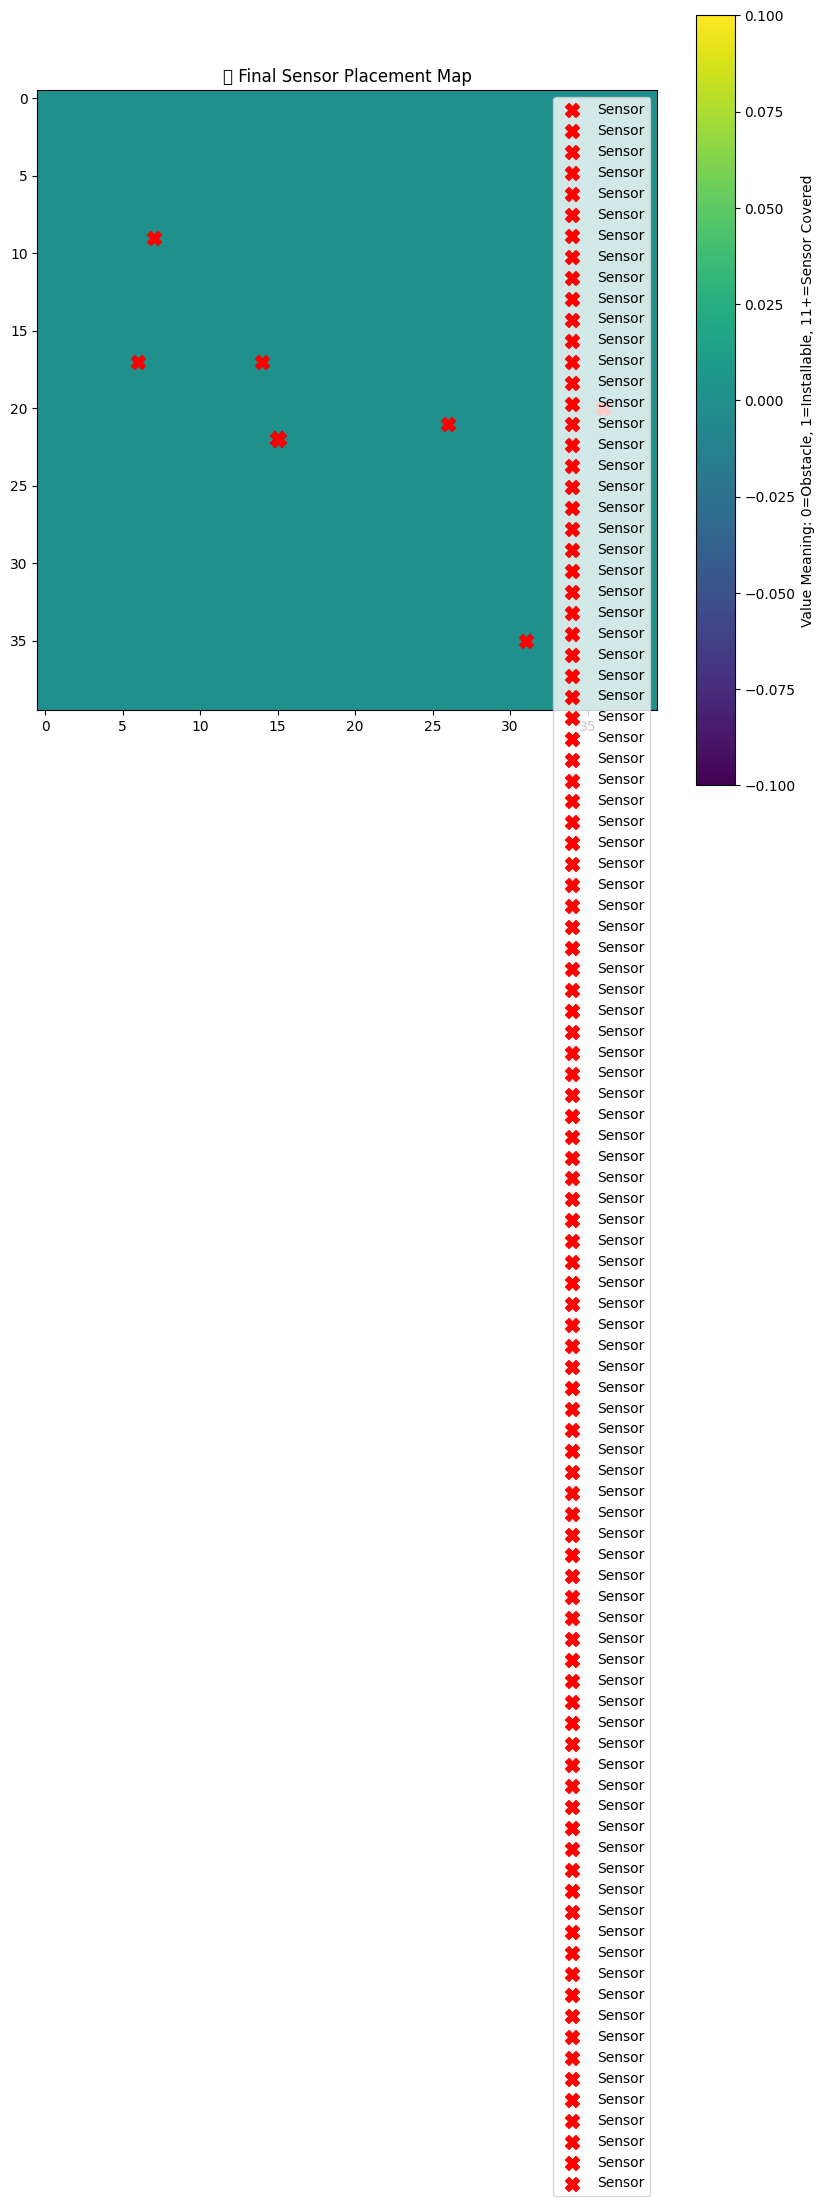

In [ ]:
# Reinforcement 객체에서 맵 상태 가져오기
final_map = env.reinforce.get_numeric_state().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(final_map, cmap='viridis')
plt.title("📡 Final Sensor Placement Map")
plt.colorbar(label="Value Meaning: 0=Obstacle, 1=Installable, 11+=Sensor Covered")

# 센서 좌표에 점 찍기
for (x, y) in sensor_positions:
    plt.scatter(y, x, c='red', s=100, marker='X', label='Sensor')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
print(sensor_positions)

[(19, 37), (19, 37), (19, 37), (19, 37), (19, 37), (19, 37), (19, 37), (19, 37), (19, 37), (19, 37)]


In [ ]:
# 평가자 입력 준비: 현재 커버 상태 기반
evaluator_input = env.reinforce.get_numeric_state().unsqueeze(0).unsqueeze(0).float()

# 평가자 모델 로딩 또는 초기화
evaluator = PlacementHeatmapEvaluator()
evaluator.eval()

# 평가 결과 얻기
with torch.no_grad():
    score_map = evaluator(evaluator_input).squeeze(0)

plt.figure(figsize=(10, 10))
plt.imshow(score_map.numpy(), cmap='coolwarm')
plt.title("📊 Evaluated Placement Score (by Evaluator)")
plt.colorbar()
plt.show()


NameError: name 'PlacementHeatmapEvaluator' is not defined